In [1]:
import numpy as np
from matplotlib import pyplot as plt

from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Lambda
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import AveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import add, concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
import tensorflow
from tensorflow.keras.regularizers import L2

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.debugging.set_log_device_placement(False)

In [4]:
# batch operation usng tensor slice
def WaveletTransformAxisY(batch_img):
    odd_img  = batch_img[:,0::2]
    even_img = batch_img[:,1::2]
    L = (odd_img + even_img) / 2.0
    H = K.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = K.permute_dimensions(batch_img, [0, 2, 1])[:,:,::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = K.permute_dimensions(_dst_L, [0, 2, 1])[:,::-1,...]
    dst_H = K.permute_dimensions(_dst_H, [0, 2, 1])[:,::-1,...]
    return dst_L, dst_H

In [5]:
def Wavelet(batch_image):
    # make channel first image
    batch_image = K.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:,0]
    g = batch_image[:,1]
    b = batch_image[:,2]

    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(g)
    g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(b)
    b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH, 
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    transform_batch = K.stack(wavelet_data, axis=1)

    # level 2 decomposition
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
    g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
    b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)


    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2, 
                    g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                    b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    transform_batch_l2 = K.stack(wavelet_data_l2, axis=1)

    # level 3 decomposition
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
    g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
    b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3, 
                    g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                    b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    transform_batch_l3 = K.stack(wavelet_data_l3, axis=1)

    # level 4 decomposition
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
    g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL3)
    b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)


    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4, 
                    g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                    b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    transform_batch_l4 = K.stack(wavelet_data_l4, axis=1)

    # print('shape before')
    # print(transform_batch.shape)
    # print(transform_batch_l2.shape)
    # print(transform_batch_l3.shape)
    # print(transform_batch_l4.shape)

    decom_level_1 = K.permute_dimensions(transform_batch, [0, 2, 3, 1])
    decom_level_2 = K.permute_dimensions(transform_batch_l2, [0, 2, 3, 1])
    decom_level_3 = K.permute_dimensions(transform_batch_l3, [0, 2, 3, 1])
    decom_level_4 = K.permute_dimensions(transform_batch_l4, [0, 2, 3, 1])
    
    # print('shape after')
    # print(decom_level_1.shape)
    # print(decom_level_2.shape)
    # print(decom_level_3.shape)
    # print(decom_level_4.shape)
    return [decom_level_1, decom_level_2, decom_level_3, decom_level_4]


def Wavelet_out_shape(input_shapes):
    # print('in to shape')
    return [tuple([None, 96, 96, 12]), tuple([None, 48, 48, 12]), 
            tuple([None, 24, 24, 12]), tuple([None, 12, 12, 12])]

In [6]:
img_batch = K.zeros(shape=(8, 224, 224, 3), dtype='float32')
[x.shape for x in Wavelet(img_batch)]

[TensorShape([8, 112, 112, 12]),
 TensorShape([8, 56, 56, 12]),
 TensorShape([8, 28, 28, 12]),
 TensorShape([8, 14, 14, 12])]

In [7]:
def get_wavelet_cnn_model():

    input_shape = 192, 192, 3

    input_ = Input(input_shape, name='the_input')
    # wavelet = Lambda(Wavelet, name='wavelet')
    wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)
    # print(input_l1)
    # print(input_l2)
    # print(input_l3)
    # print(input_l4)
    # level one decomposition starts
    conv_1 = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_1')(input_l1)
    norm_1 = BatchNormalization(name='norm_1')(conv_1)
    relu_1 = Activation('relu', name='relu_1')(norm_1)

    conv_1_2 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2')(relu_1)
    norm_1_2 = BatchNormalization(name='norm_1_2')(conv_1_2)
    relu_1_2 = Activation('relu', name='relu_1_2')(norm_1_2)

    # level two decomposition starts
    conv_a = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_a')(input_l2)
    norm_a = BatchNormalization(name='norm_a')(conv_a)
    relu_a = Activation('relu', name='relu_a')(norm_a)

    # concate level one and level two decomposition
    concate_level_2 = concatenate([relu_1_2, relu_a])
    conv_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_2')(concate_level_2)
    norm_2 = BatchNormalization(name='norm_2')(conv_2)
    relu_2 = Activation('relu', name='relu_2')(norm_2)

    conv_2_2 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_2_2')(relu_2)
    norm_2_2 = BatchNormalization(name='norm_2_2')(conv_2_2)
    relu_2_2 = Activation('relu', name='relu_2_2')(norm_2_2)

    # level three decomposition starts 
    conv_b = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_b')(input_l3)
    norm_b = BatchNormalization(name='norm_b')(conv_b)
    relu_b = Activation('relu', name='relu_b')(norm_b)

    conv_b_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_b_2')(relu_b)
    norm_b_2 = BatchNormalization(name='norm_b_2')(conv_b_2)
    relu_b_2 = Activation('relu', name='relu_b_2')(norm_b_2)

    # concate level two and level three decomposition 
    concate_level_3 = concatenate([relu_2_2, relu_b_2])
    conv_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_3')(concate_level_3)
    norm_3 = BatchNormalization(name='nomr_3')(conv_3)
    relu_3 = Activation('relu', name='relu_3')(norm_3)

    conv_3_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_3_2')(relu_3)
    norm_3_2 = BatchNormalization(name='norm_3_2')(conv_3_2)
    relu_3_2 = Activation('relu', name='relu_3_2')(norm_3_2)

    # level four decomposition start
    conv_c = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_c')(input_l4)
    norm_c = BatchNormalization(name='norm_c')(conv_c)
    relu_c = Activation('relu', name='relu_c')(norm_c)

    conv_c_2 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_2')(relu_c)
    norm_c_2 = BatchNormalization(name='norm_c_2')(conv_c_2)
    relu_c_2 = Activation('relu', name='relu_c_2')(norm_c_2)

    conv_c_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_3')(relu_c_2)
    norm_c_3 = BatchNormalization(name='norm_c_3')(conv_c_3)
    relu_c_3 = Activation('relu', name='relu_c_3')(norm_c_3)

    # concate level level three and level four decomposition
    concate_level_4 = concatenate([relu_3_2, relu_c_3])
    conv_4 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_4')(concate_level_4)
    norm_4 = BatchNormalization(name='norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(norm_4)

    conv_4_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_4_2')(relu_4)
    norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
    relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)

    conv_5_1 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_5_1')(relu_4_2)
    norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
    relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)

    pool_5_1 = AveragePooling2D(pool_size=(7, 7), strides=1, padding='same', name='avg_pool_5_1')(relu_5_1)
    flat_5_1 = Flatten(name='flat_5_1')(pool_5_1) 

    fc_5 = Dense(2048, name='fc_5')(flat_5_1)
    norm_5 = BatchNormalization(name='norm_5')(fc_5)
    relu_5 = Activation('relu', name='relu_5')(norm_5)
    drop_5 = Dropout(0.5, name='drop_5')(relu_5)

    fc_6 = Dense(2048, name='fc_6')(drop_5)
    norm_6 = BatchNormalization(name='norm_6')(fc_6)
    relu_6 = Activation('relu', name='relu_6')(norm_6)
    drop_6 = Dropout(0.5, name='drop_6')(relu_6)

    output = Dense(11, activation='softmax', name='fc_7')(drop_6)

    model = Model(inputs=input_, outputs=output)
    model.summary()
    plot_model(model, to_file='wavelet_cnn_0.5.png')

    return model

In [8]:
model = get_wavelet_cnn_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 the_input (InputLayer)         [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 wavelet (Lambda)               [(None, 96, 96, 12)  0           ['the_input[0][0]']              
                                , (None, 48, 48, 12                                               
                                ),                                                                
                                 (None, 24, 24, 12)                                               
                                , (None, 12, 12, 12                                           

 norm_3_2 (BatchNormalization)  (None, 12, 12, 256)  1024        ['conv_3_2[0][0]']               
                                                                                                  
 norm_c_3 (BatchNormalization)  (None, 12, 12, 256)  1024        ['conv_c_3[0][0]']               
                                                                                                  
 relu_3_2 (Activation)          (None, 12, 12, 256)  0           ['norm_3_2[0][0]']               
                                                                                                  
 relu_c_3 (Activation)          (None, 12, 12, 256)  0           ['norm_c_3[0][0]']               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 12, 12, 512)  0           ['relu_3_2[0][0]',               
                                                                  'relu_c_3[0][0]']               
          

In [9]:
opt=tensorflow.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
train_data_dir = 'kth_tips_grey_200x200/KTH-TIPS2-b'

In [15]:
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1) # et validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(192, 192),
    batch_size=16,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(192, 192),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # set as validation a

history=model.fit(
    train_generator,
    validation_data = validation_generator, 
    epochs = 40,
    callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)])

Found 4279 images belonging to 11 classes.
Found 473 images belonging to 11 classes.
Epoch 1/40
268/268 [==============================] - 29s 108ms/step - loss: 3.0146 - accuracy: 0.4606 - val_loss: 4.0704 - val_accuracy: 0.3319
Epoch 2/40
268/268 [==============================] - 30s 110ms/step - loss: 2.1258 - accuracy: 0.5611 - val_loss: 2.1901 - val_accuracy: 0.4989
Epoch 3/40
268/268 [==============================] - 29s 109ms/step - loss: 1.7649 - accuracy: 0.5733 - val_loss: 1.4113 - val_accuracy: 0.5624
Epoch 4/40
268/268 [==============================] - 29s 109ms/step - loss: 1.3281 - accuracy: 0.6172 - val_loss: 0.9198 - val_accuracy: 0.7252
Epoch 5/40
268/268 [==============================] - 29s 108ms/step - loss: 1.0665 - accuracy: 0.6525 - val_loss: 1.7528 - val_accuracy: 0.4693
Epoch 6/40
268/268 [==============================] - 29s 108ms/step - loss: 0.9460 - accuracy: 0.6714 - val_loss: 1.0007 - val_accuracy: 0.7040
Epoch 7/40
268/268 [=========================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


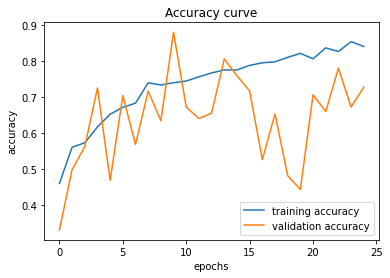

In [16]:
acc = history.history['accuracy']
print(history.history.keys())
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
plt.plot(acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Accuracy curve')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

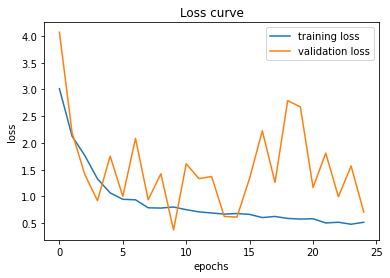

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [21]:
model.save('saved_model\WaveLetCNN')

INFO:tensorflow:Assets written to: saved_model\WaveLetCNN\assets


INFO:tensorflow:Assets written to: saved_model\WaveLetCNN\assets
